In [ ]:
'''Classification of Artificially Generated Faces Using Transfer Learning
dataset source: https://www.kaggle.com/xhlulu/140k-real-and-fake-faces

I recommend reading the write-up attached first. The size of the pdf seems large at first,
however most of it is just pictures and graphs, that are easily interpretable. I used
VGG16 as well as MobileNetV3 for its applications with transfer learning. Due to the size
of the latter, I omitted the summary() architecture.

Initially this was done over https://www.kaggle.com/ciplab/real-and-fake-face-detection this dataset
instead, however given my low val_accuracy and high overfitting, I realized that my model could
not generalize properly, and that even with the number of dropout layers, batch normalization,
lowered learning rates, introduced dense layers, parameter tuning, nothing worked. So I switched
to the current dataset which contains 140k images. The previous dataset contained 2k images.
'''


In [248]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV3Small
from tensorflow.keras import models, layers, optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import seaborn as sns
import pandas as pd
%matplotlib inline 

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6



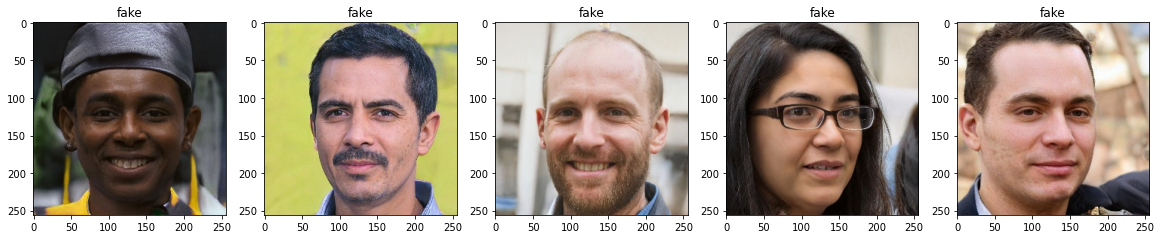

In [196]:
plt.figure(figsize=(20,20))

ex_fake_folder = r'real_vs_fake\test\fake'
ex_real_folder = r'real_vs_fake\test\real'
IMG_WIDTH = 224
IMG_HEIGHT = 224

for i in range(5):
    file = random.choice(os.listdir(ex_fake_folder))
    image_path = os.path.join(ex_fake_folder, file)
    img = plt.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text('fake')
    plt.imshow(img)
    

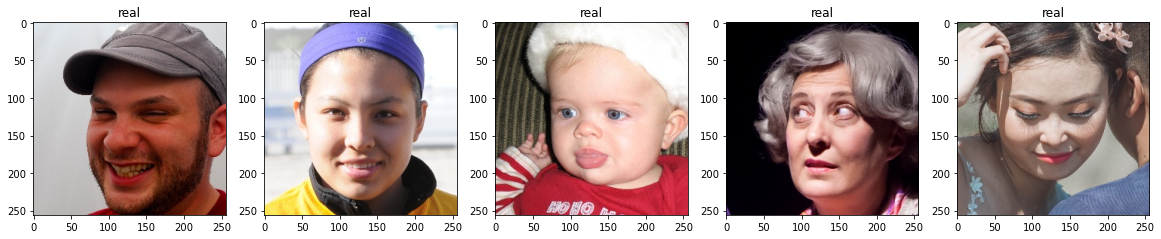

In [197]:
plt.figure(figsize=(20,20))

for i in range(5):
    file = random.choice(os.listdir(ex_real_folder))
    image_path = os.path.join(ex_real_folder, file)
    img = plt.imread(image_path)
    ax1=plt.subplot(1,5,i+1)
    ax1.title.set_text('real')
    plt.imshow(img)

In [178]:
'''source: https://vijayabhaskar96.medium.com/
tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720'''
'''one thing to note is you have to set shuffle=False for the test batch. This is because the
labels get shifted and you can't predict correctly without it. It's super weird and I should've
just created my own code instead of relying on Keras's generative methods'''

image_gen = ImageDataGenerator()

train = image_gen.flow_from_directory(
    'real_vs_fake/train/',
    class_mode='binary',
    shuffle=True,
    target_size=(224,224),
    batch_size=64
)

valid = image_gen.flow_from_directory(
    'real_vs_fake/valid/',
    class_mode='binary',
    shuffle=True,
    target_size=(224,224),
    batch_size=64
) 
test = image_gen.flow_from_directory(
    'real_vs_fake/test/',
    class_mode='binary',
    shuffle=False,
    target_size=(224,224),
    batch_size=1
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [7]:
'''simple model I came up with to trial run the data'''
simple_model = models.Sequential([
    layers.Flatten(input_shape=[224,224,3]),
    layers.Dense(256, activation = 'LeakyReLU'),
    layers.Dense(2, activation='softmax')
])

simple_model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
simple_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 38,535,938
Trainable params: 38,535,938
Non-trainable params: 0
_________________________________________________________________


In [8]:
'''my code was not working initially so i thought using the fit_generator instead of fit() would
change things. It didn't and but my code was fixed, but because I already trained the model,
I didn't want to re-train it with the new code. The same is said for the next couple models'''
simple_history=simple_model.fit_generator(
    train,
    epochs=3,
    validation_data=valid,
    verbose=1
)

C:\Users\Peter\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1945: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
1563/1563 [==============================] - 162s 103ms/step - loss: 7.9245 - accuracy: 0.6135 - val_loss: 2.9848 - val_accuracy: 0.6554
Epoch 2/3
1563/1563 [==============================] - 135s 86ms/step - loss: 2.5683 - accuracy: 0.6634 - val_loss: 1.1615 - val_accuracy: 0.7056
Epoch 3/3
1563/1563 [==============================] - 148s 95ms/step - loss: 1.1895 - accuracy: 0.6890 - val_loss: 0.5943 - val_accuracy: 0.7470


In [56]:
'''according to https://www.kaggle.com/xhlulu/140k-real-and-fake-faces/tasks?taskId=530
The metric is the F score, which is readily available with tensorflow's metric library.
It measures a model's accuracy, and the best score is 1, which means it has
perfect precision and recall.

Precision = correctly identified relevant positives (true relevant positives/all positives)
Recall = relevant instances that were retrieved (true positives / relevant elements)

F1 = precision * recall / (precision + recall)
'''
y_pred = simple_model.predict(test)
y_pred = np.argmax(y_pred, axis=1)
y_test = test.classes

print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))

AP Score: 0.6718259198902137
              precision    recall  f1-score   support

           0       0.79      0.66      0.72     10000
           1       0.71      0.83      0.76     10000

    accuracy                           0.74     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.75      0.74      0.74     20000



[[0.72722995 0.27277005]]


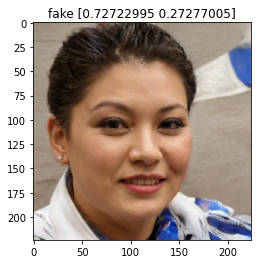

In [63]:
#image = cv2.imread(r'real_vs_fake\test\real\00045.jpg', cv2.COLOR_BGR2RGB)
image = cv2.imread(r'real_vs_fake\test\fake\0M776S0CZQ.jpg', cv2.COLOR_BGR2RGB)

image = cv2.resize(image,(IMG_HEIGHT,IMG_WIDTH), interpolation = cv2.INTER_AREA)
image = np.array(image)
image = image.astype('float32')
image /= 255
image = image[:,:,::-1]

img = cv2.resize(image,(224,224))     # resize image to match model's expected sizing
img = img.reshape(1,224,224,3)
result = simple_model.predict(img)
print(result)
if result[0][0] > result[0][1]:
    classification = 'fake '
else:
    classification = 'real '

plt.title(classification + str(result[0]))
plt.imshow(image)
plt.show()

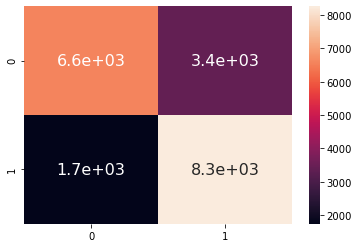

In [64]:
cm = metrics.confusion_matrix(test.classes, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True, annot_kws={"size": 16})
plt.show()

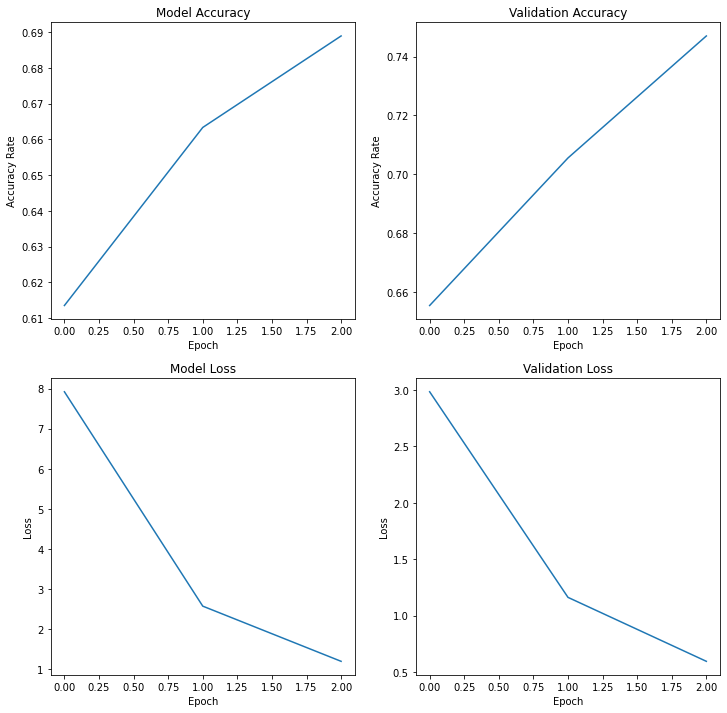

In [65]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0,0].plot(simple_history.history['accuracy'])
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(simple_history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(simple_history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(simple_history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
plt.show()

In [13]:
simple_model1 = models.Sequential([
    layers.Conv2D(filters=1, kernel_size = (5,5), input_shape = [224,224,3], activation='linear'),
    layers.MaxPooling2D(pool_size = 50, padding='same'),
    layers.Flatten(),
    layers.Dense(256, activation = 'LeakyReLU'),
    layers.Dense(units=2,activation='softmax')
])

simple_model1.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
simple_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 1)       76        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6656      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 7,246
Trainable params: 7,246
Non-trainable params: 0
_________________________________________________________________


In [14]:
simple_history1=simple_model1.fit(train,
                  validation_data=valid,
                  batch_size=64,
                  epochs=3,
                  verbose=2,
                  shuffle=False,
                  callbacks=[early_stopping]
)

Epoch 1/3
1563/1563 - 165s - loss: 0.6429 - accuracy: 0.6257 - val_loss: 0.6309 - val_accuracy: 0.6491
Epoch 2/3
1563/1563 - 131s - loss: 0.6188 - accuracy: 0.6579 - val_loss: 0.6162 - val_accuracy: 0.6653
Epoch 3/3
1563/1563 - 131s - loss: 0.6108 - accuracy: 0.6671 - val_loss: 0.6133 - val_accuracy: 0.6663


In [70]:
y_pred = simple_model1.predict_generator(test)
y_pred = np.argmax(y_pred, axis=1)
y_test = test.classes

print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.6729999999999999
AP Score: 0.6164829693448206

              precision    recall  f1-score   support

           0       0.67      0.67      0.67     10000
           1       0.67      0.67      0.67     10000

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000



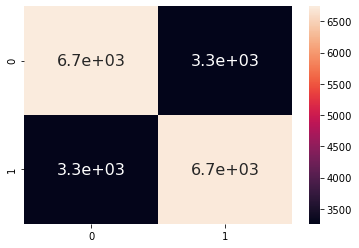

In [71]:
cm = metrics.confusion_matrix(test.classes, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True, annot_kws={"size": 16})
plt.show()

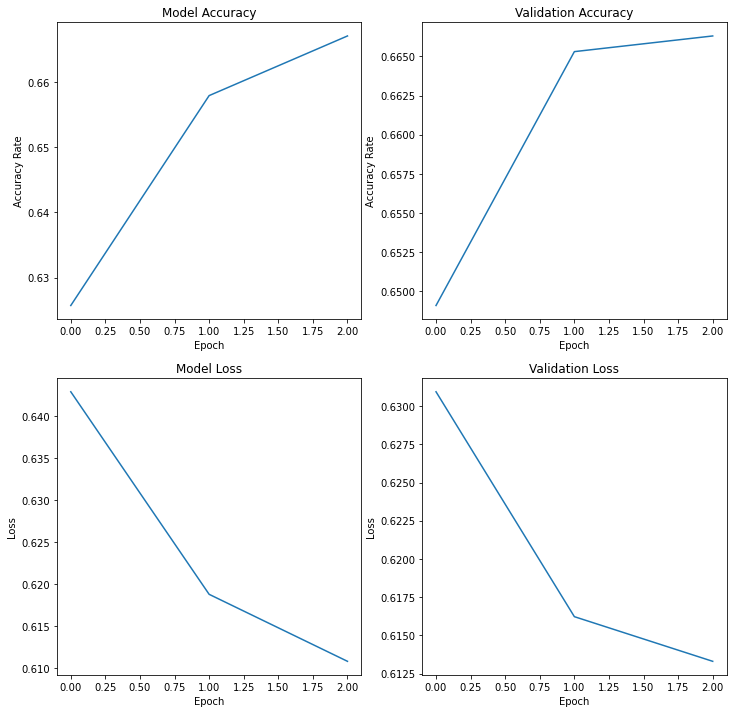

In [19]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0,0].plot(simple_history1.history['accuracy'])
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(simple_history1.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(simple_history1.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(simple_history1.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
plt.show()

In [331]:
new_input = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
mobilenet_model = MobileNetV3Small(include_top = False,weights='imagenet', input_tensor = new_input, classes = 2)
#mobilenet_model.summary()

In [91]:
for layer in mobilenet_model.layers:
    layers.trainable = False

model = Sequential()
model.add(mobilenet_model)
model.add(layers.Flatten())
model.add(layers.Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 2050      
Total params: 1,532,018
Trainable params: 1,519,906
Non-trainable params: 12,112
_________________________________________________________________


In [92]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer=optimizers.Adam(learning_rate=5e-5),
metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
mobile_history=model.fit(
    train,
    epochs=5,
    validation_data=valid,
    verbose=1
)

Epoch 1/5
1563/1563 [==============================] - 164s 102ms/step - loss: 0.2127 - accuracy: 0.9090 - val_loss: 0.1966 - val_accuracy: 0.9209
Epoch 2/5
1563/1563 [==============================] - 158s 101ms/step - loss: 0.0682 - accuracy: 0.9747 - val_loss: 0.0584 - val_accuracy: 0.9783
Epoch 3/5
1563/1563 [==============================] - 157s 101ms/step - loss: 0.0380 - accuracy: 0.9862 - val_loss: 0.0473 - val_accuracy: 0.9831
Epoch 4/5
1563/1563 [==============================] - 157s 101ms/step - loss: 0.0216 - accuracy: 0.9921 - val_loss: 0.0844 - val_accuracy: 0.9707
Epoch 5/5
1563/1563 [==============================] - 156s 100ms/step - loss: 0.0148 - accuracy: 0.9945 - val_loss: 0.1082 - val_accuracy: 0.9649


In [96]:
y_pred = model.predict(test)
y_pred = np.argmax(y_pred, axis=1)
y_test = test.classes
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))

AP Score: 0.9372203581836984
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     10000
           1       0.94      1.00      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



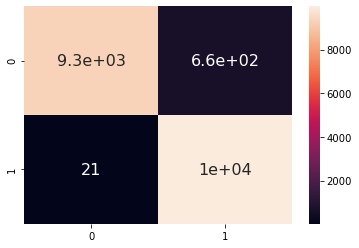

In [100]:
cm = metrics.confusion_matrix(test.classes, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True, annot_kws={"size": 16})
plt.show()

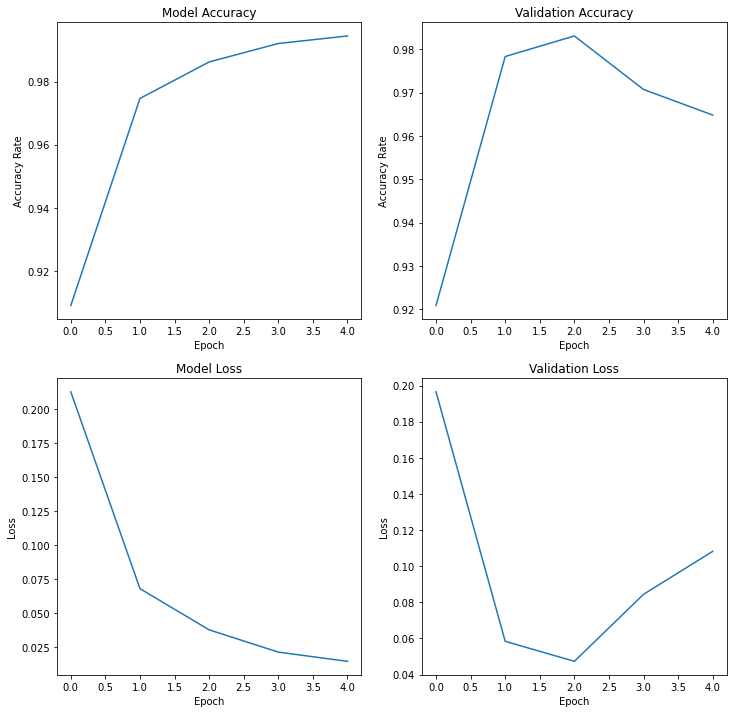

In [101]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0,0].plot(mobile_history.history['accuracy'])
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(mobile_history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(mobile_history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(mobile_history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
plt.show()

In [30]:
new_input = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
VGG_model = VGG16(include_top = False,weights='imagenet', input_tensor = new_input, classes = 2)
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
for layer in VGG_model.layers[:15]:
    layers.trainable = False

model1 = Sequential()
model1.add(VGG_model)
# model1.add(layers.Flatten())
# model1.add(layers.BatchNormalization())
# model1.add(layers.Dense(256, activation = 'PReLU'))
# model1.add(layers.Dropout(0.4))
# model1.add(layers.Dense(256, activation = 'PReLU'))
# #model1.add(layers.BatchNormalization())
model1.add(layers.Flatten())
model1.add(layers.Dense(units=2, activation='softmax'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 14,764,866
Non-trainable params: 0
_________________________________________________________________


In [32]:
model1.compile(loss='sparse_categorical_crossentropy',
optimizer=optimizers.Adam(learning_rate=5e-5),
metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
vgg_history=model1.fit(train,
                  validation_data=valid,
                  batch_size=32,
                  epochs=3,
                  verbose=2,
                  shuffle=False,
                  #callbacks=[early_stopping]
)

Epoch 1/3
1563/1563 - 774s - loss: 0.2001 - accuracy: 0.9132 - val_loss: 0.1046 - val_accuracy: 0.9596
Epoch 2/3
1563/1563 - 761s - loss: 0.0547 - accuracy: 0.9799 - val_loss: 0.0710 - val_accuracy: 0.9729
Epoch 3/3
1563/1563 - 766s - loss: 0.0334 - accuracy: 0.9874 - val_loss: 0.0334 - val_accuracy: 0.9883


In [193]:
y_pred = model1.predict_generator(test)
y_pred = np.argmax(y_pred, axis=1)
y_test = test.classes

print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))

AP Score: 0.9054421728056427
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     10000
           1       0.93      0.95      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



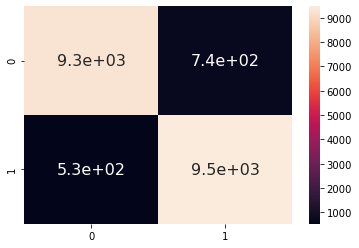

In [194]:
cm = metrics.confusion_matrix(test.classes, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True, annot_kws={"size": 16})
plt.show()

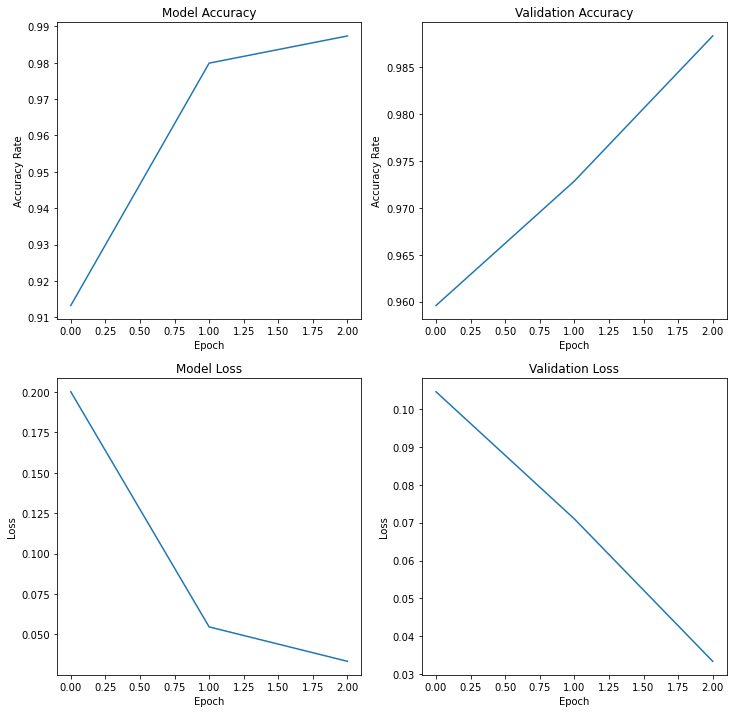

In [104]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0,0].plot(vgg_history.history['accuracy'])
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(vgg_history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(vgg_history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(vgg_history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
plt.show()

In [36]:
model1.save('140k_dataset', save_format="h5")

In [37]:
model1 = tf.keras.models.load_model('140k_dataset')

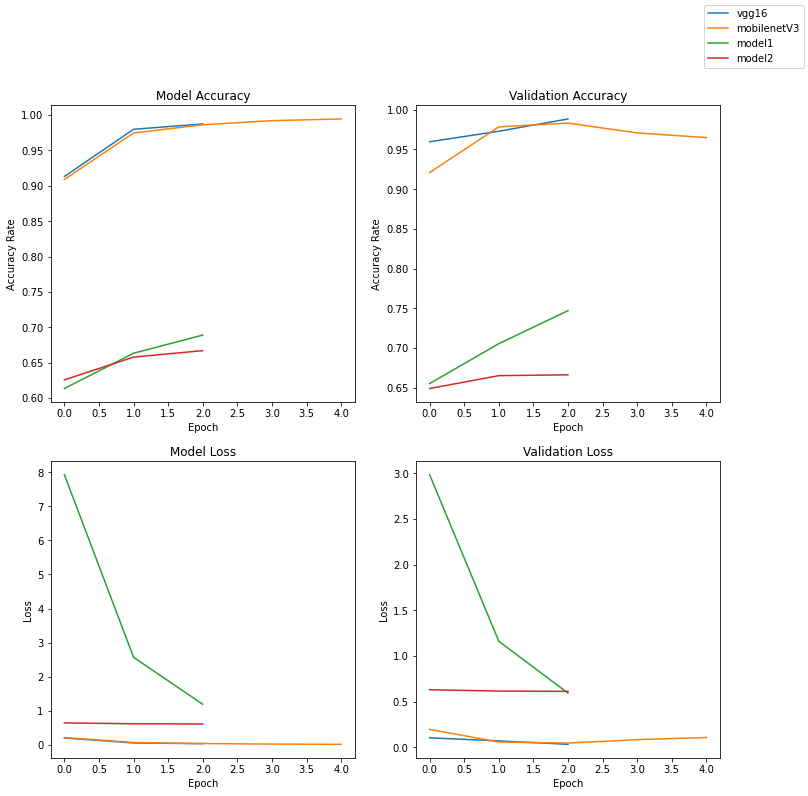

In [205]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0,0].plot(vgg_history.history['accuracy'],label='vgg16')
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(vgg_history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(vgg_history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(vgg_history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
axs[0,0].plot(mobile_history.history['accuracy'],label='mobilenetV3')
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(mobile_history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(mobile_history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(mobile_history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
axs[0,0].plot(simple_history.history['accuracy'],label='model1')
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(simple_history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(simple_history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(simple_history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
axs[0,0].plot(simple_history1.history['accuracy'],label='model2')
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(simple_history1.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(simple_history1.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(simple_history1.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
fig.legend()
plt.show()

In [336]:
def tester(img_location,i):
    image = cv2.imread('real_vs_fake\\test\\'+img_location, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224), interpolation = cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255
    image = image[:,:,::-1]

    img = cv2.resize(image,(224,224))     # resize image to match model's expected sizing
    img = img.reshape(1,224,224,3)
    result = np.argmax(model1.predict(img),axis=1)
    print(result)
    if result[0] == 0:
        classification = 'fake '
    else:
        classification = 'real '

    ax1=plt.subplot(3,8,i+1)
    ax1.title.set_text(classification)# + str(result[0]))
    plt.imshow(image)
        


[0]
[0]
[0]
[0]
[0]


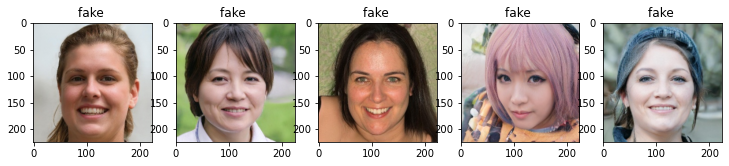

In [329]:
plt.figure(figsize=(20,20))

tester('fake\\0F7NBTSSZ5.jpg',0)
tester('fake\\0HWQTCJXJS.jpg',1)
tester('fake\\0ARJBWDKA1.jpg',2)
tester('fake\\0BLEO0FWIY.jpg',3)
tester('fake\\0J519262KL.jpg',4)


[1]
[1]
[1]
[1]
[1]


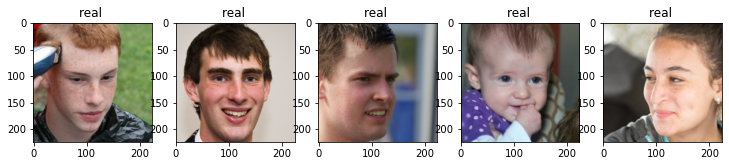

In [337]:
plt.figure(figsize=(20,20))

tester('real\\00053.jpg',0)
tester('real\\00113.jpg',1)
tester('real\\00495.jpg',2)
tester('real\\00843.jpg',3)
tester('real\\01684.jpg',4)